# CNN for TFBS predictions and model interpretability

In this notebook we will how easy it is to train a CNN on DNA data contains binding sites for proteins, make predictions for Transcription Factor Binding Sites (TFBS) and extract the learned motif with a simple gradient-based method.

## Load Necessary Libraries

In [1]:
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.python.keras.layers.core import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

## Load the sequence data

In [2]:
input_fasta_data = pd.read_table("sequences_mod.txt", header=None)
input_fasta_data.rename(columns={0: "sequence"}, inplace=True)
sequence_length = len(input_fasta_data.sequence[0])
print(sequence_length)
print(input_fasta_data.head())
print()
print(input_fasta_data.tail())

50
                                            sequence
0  CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
1  GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
2  GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
3  GTCCAAAAGAGGAAGTTCACCTTGACCGCAGAGGTACCACCAGAGC...
4  GGAAAGAGGAAGTTAACTAGAACCTGCATAACTGGCCTGGGAGATA...

                                               sequence
1995  GTCGCGCGGGTGCGGAGGATGAGTCGCAGACGCATTTATGTCGCCC...
1996  GTTCGCAGCGTATTGAGTAATGTTTGACTAAAGAGGAAGTTATATT...
1997  ACTCGCTGTCCACGTCTATTCCTAGGGGTTTTATTTCGCAAGGTGA...
1998  TGCAAAGGGGAAAGAGGAAGTTCTTTACCGCGGAGTTATTCATAAT...
1999  AATGTAAAGAGGAAGTTGCACTGCTGGCCCGGGCCTATATCGAGAG...


## Feature extraction and OHE

In [3]:
iec = LabelEncoder()
ohe = OneHotEncoder(categories='auto')
seq_matrix = []
for sequence in input_fasta_data.sequence:
  iecd = iec.fit_transform(list(sequence))
  iecd = np.array(iecd).reshape(-1, 1)
  ohed = ohe.fit_transform(iecd)
  seq_matrix.append(ohed.toarray())
seq_matrix = np.stack(seq_matrix)
print(seq_matrix.shape)
print(seq_matrix)

(2000, 50, 4)
[[[0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]
  ...
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 0. 1. 0.]
  ...
  [0. 0. 0. 1.]
  [0. 1. 0. 0.]
  [0. 0. 1. 0.]]

 [[0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  ...
  [0. 1. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]]

 ...

 [[1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]
  ...
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]
  [0. 0. 0. 1.]]

 [[0. 0. 0. 1.]
  [0. 0. 1. 0.]
  [0. 1. 0. 0.]
  ...
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]]

 [[1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]
  ...
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]]


## Target labels

In [4]:
labels = pd.read_csv('labels.txt')
Labels = np.array(labels).reshape(-1)
print(Labels[:5])
iecd = iec.fit_transform(Labels[:])
iecd = np.array(iecd).reshape(-1, 1)
ohed = ohe.fit_transform(iecd)
Y = np.stack(ohed.toarray())
print(Y.shape)
print(Y)

[0 0 0 1 1]
(2000, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


### Distribution of Positive and Negative samples

In [5]:
print(pd.DataFrame(Labels).value_counts())

0    1013
1     987
Name: count, dtype: int64


# Train-test split
Before we train the model, let’s split the dataset into training and test datasets so that we can use
training data for model training and test data for model evaluation:

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(seq_matrix, Y, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape
print(X_train.shape)
print(Y_train.shape)

(1500, 50, 4)
(1500, 2)


In [23]:
# Reshaping the data so it corresponds to the input format of keras
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
print(X_train.shape, X_train_reshaped.shape)
print(X_test.shape, X_test_reshaped.shape)

(1500, 50, 4) (1500, 50, 4, 1)
(500, 50, 4) (500, 50, 4, 1)


## Create a CNN

We start with a fairly simple NN architeture of a single convolutional layer followed by a max-pooling layer
and then a single dense layer.

In [24]:
dropout = 0.2
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, input_shape=(50, 4), padding='same'))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 50, 32)            1568      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 10, 32)            0         
 g1D)                                                            
                                                                 
 module_wrapper_45 (ModuleW  (None, 320)               0         
 rapper)                                                         
                                                                 
 module_wrapper_46 (ModuleW  (None, 256)               82176     
 rapper)                                                         
                                                                 
 module_wrapper_47 (ModuleW  (None, 256)               0         
 rapper)                                              

# Fit the model

In [25]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=['accuracy'])

In [26]:
history = model.fit(X_train_reshaped, Y_train,
          batch_size=10, epochs=10,
          validation_split=0.1)

Epoch 1/10
135/135 [==============================] - 2s 6ms/step - loss: 0.6946 - accuracy: 0.4822 - val_loss: 0.6925 - val_accuracy: 0.5133
Epoch 2/10
135/135 [==============================] - 1s 4ms/step - loss: 0.6941 - accuracy: 0.5052 - val_loss: 0.6925 - val_accuracy: 0.5133
Epoch 3/10
135/135 [==============================] - 1s 4ms/step - loss: 0.6953 - accuracy: 0.5015 - val_loss: 0.6899 - val_accuracy: 0.7667
Epoch 4/10
135/135 [==============================] - 1s 6ms/step - loss: 0.6913 - accuracy: 0.5237 - val_loss: 0.6756 - val_accuracy: 0.5267
Epoch 5/10
135/135 [==============================] - 1s 7ms/step - loss: 0.6580 - accuracy: 0.6356 - val_loss: 0.7625 - val_accuracy: 0.4867
Epoch 6/10
135/135 [==============================] - 1s 7ms/step - loss: 0.4034 - accuracy: 0.8244 - val_loss: 0.3172 - val_accuracy: 0.8867
Epoch 7/10
135/135 [==============================] - 1s 7ms/step - loss: 0.2243 - accuracy: 0.9207 - val_loss: 0.0783 - val_accuracy: 0.9800
Epoch 

# Visualization

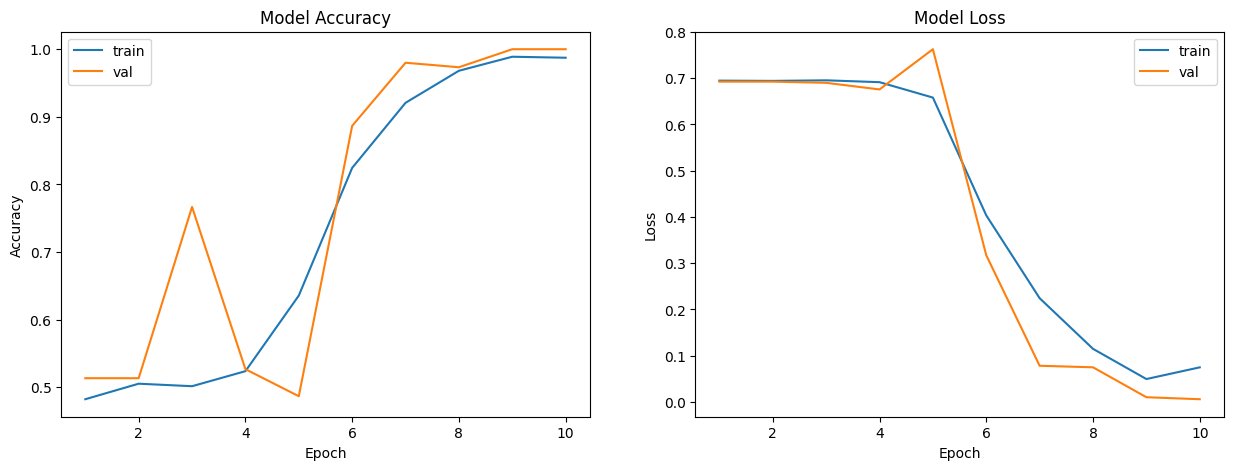

In [27]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='best')
axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='best')
plt.show()

## Evaluating the Model

Using metrics such as AUC and AUPRC

In [28]:
# Model predictions
pred = model.predict(X_test_reshaped, batch_size=32).flatten()
pred_final = np.argmax(pred.reshape(-1, 2), axis=1)
Y_final = np.argmax(Y_test, axis=1)

16/16 [==============================] - 0s 4ms/step


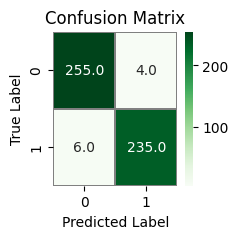

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_final.astype(str), pred_final.astype(str))
# plot the confusion matrix
f,ax = plt.subplots(figsize=(2, 2))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [30]:
# Model metrics such as AUC to get an estimate how good the NN actually learned
fpr, tpr, thresholds = roc_curve(Y_final, pred_final)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_final, pred_final))

AUC 0.9798298594979094
AUPRC 0.9707840066667823


## Make a saliency plot:

In [31]:
# Plot the motif for the sequences
plot_ids = np.random.randint(0, len(X_test), 1)

# Get the Y ~ X for the sequences we want to plot
seq_matrix_plot = seq_matrix.reshape((seq_matrix.shape[0], seq_matrix.shape[1], seq_matrix.shape[2], 1))[plot_ids, :]
print(seq_matrix_plot.shape)
seq_matrix_plot_pred = model.predict(seq_matrix_plot, batch_size=32).flatten()
print("seq_matrix_plot_pred ", seq_matrix_plot_pred)

(1, 50, 4, 1)
1/1 [==============================] - 0s 65ms/step
seq_matrix_plot_pred  [0.9981085  0.00189149]


## Calculate Gradient

In [32]:
# Generate a new set of X where for each sequence every nucleotide is consecutively set to 0
X = np.repeat(seq_matrix_plot, 50, axis=0)

first = np.ones((50, 50), int)
np.fill_diagonal(first, 0)
second = np.repeat(first.reshape((1,50,50)), seq_matrix_plot.shape[0], axis=0)
third = np.concatenate(second, axis=0)
fourth = np.multiply(X, np.repeat(third.reshape((X.shape[0], 50, 1, 1)), 4, axis=2))

print(seq_matrix_plot.shape)
print(fourth.shape)

(1, 50, 4, 1)
(50, 50, 4, 1)


In [33]:
# Calculate the prediction for each sequence with one deleted nucleotide
fourth_pred = model.predict(fourth, batch_size=32).flatten()
seq_matrix_plot_pred = np.argmax(seq_matrix_plot_pred.reshape(-1, 2), axis=1)
fourth_pred = np.argmax(fourth_pred.reshape(-1, 2), axis=1)

# Calculating scores
scores = np.reshape((np.repeat(seq_matrix_plot_pred, 50) - fourth_pred), (len(plot_ids),50))
# print(scores)

2/2 [==============================] - 0s 11ms/step


## Make the Motif/Saliency plot
#### I used motif_plotter package available at https://github.com/const-ae/motif_plotter. Make sure you copy the motif_plotter folder from that repo before executing this command

  Cloning https://github.com/const-ae/motif_plotter.git to /tmp/pip-req-build-1ilgzx6l
  Running command git clone --filter=blob:none --quiet https://github.com/const-ae/motif_plotter.git /tmp/pip-req-build-1ilgzx6l
  Resolved https://github.com/const-ae/motif_plotter.git to commit d261cc49ac7f5af43341bb0132048f89121022e6
  Preparing metadata (setup.py) ... done
  Created wheel for motif-plotter: filename=motif_plotter-0.2-py3-none-any.whl size=5572 sha256=5cb7af34beeb6e32bb695781d3b4bad8d9cc3f62ff0e0380ab36686b0183adfa
  Stored in directory: /tmp/pip-ephem-wheel-cache-ldnmg0j2/wheels/13/6b/75/479bc530a4457f4fb82f8b6a6df112b23b782b680c75fb8d6d
Successfully built motif-plotter


/usr/local/lib/python3.10/dist-packages/motif_plotter/__init__.py:42: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes.set_ylim(min(0,min(heights)), max(0,max(heights)))


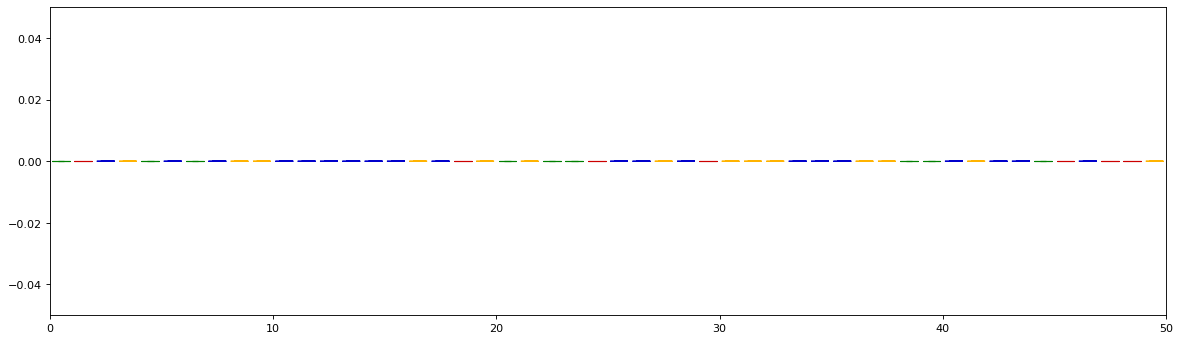

In [34]:
!pip install "git+https://github.com/const-ae/motif_plotter.git"
import motif_plotter
import matplotlib.pyplot as plt

for idx in range(0,len(plot_ids)):
    fig=plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax,
                                                seq_matrix_plot[idx].reshape((50, 4)),
                                                np.arcsinh(scores[idx]).reshape(50,1))
    plt.show()